In [1]:

from metrics import plot_confusion
from IPython.display import Image
from keras.utils import plot_model
import numpy as np
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics
from data import load_data


In [2]:
size = 10000
max_iter = 140
# entities = ['ORG', 'GPE', 'PERSON', ]  # , 'NORP',  ]
x, y, mapping, strings = load_data(size, get_text=True)
n_clusters = len(np.unique(y))+10
print(x.shape)


Loading ./data/conll_spacy_10000.pkl
Done: (37748, 772)
Train data balance:
[[   2 1454]
 [   3  102]
 [   4 1344]
 [   5 1842]
 [   6   80]
 [   7   21]
 [   8   32]
 [   9    8]
 [  10    5]
 [  11    5]
 [  12 1100]
 [  13  101]
 [  14   96]
 [  15   73]
 [  16   75]
 [  17    6]
 [  18   44]
 [  19   69]]


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


x: (33156, 768), y: (33156,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'WORK_OF_ART', 8: 'LANGUAGE', 9: 'LAW', 10: 'DATE', 11: 'TIME', 12: 'PERCENT', 13: 'MONEY', 14: 'QUANTITY', 15: 'ORDINAL', 16: 'CARDINAL', 17: 'FAC'}
(33156, 768)


In [3]:

def autoencoder_model(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is
            input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of
            the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act,
                  kernel_initializer=init, name=f'encoder_{i}')(x)

    # hidden layer
    # hidden layer, features are extracted from here
    encoded = Dense(dims[-1], kernel_initializer=init,
                    name=f'encoder_{n_stacks - 1}')(x)

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act,
                  kernel_initializer=init, name=f'decoder_{i}')(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return (Model(inputs=input_img, outputs=decoded, name='AE'),
            Model(inputs=input_img, outputs=encoded, name='encoder'))



In [4]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans = kmeans.fit_predict(x)


In [5]:
metrics.acc(y, y_pred_kmeans)


0.28649414887199903

In [6]:
dims = [x.shape[-1], 500, 500, 2000, 50]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [7]:


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=k.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (k.sum(k.square(k.expand_dims(inputs,
                   axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        # Make sure each sample's 10 values add up to 1.
        q = k.transpose(k.transpose(q) / k.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [8]:
autoencoder, encoder = autoencoder_model(dims, init=init)



In [9]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size,
                epochs=pretrain_epochs)  # , callbacks=cb)
autoencoder.save_weights(save_dir + '/jae_weights.h5')


Epoch 1/300
130/130 [==============================] - 1s 4ms/step - loss: 0.0987
Epoch 2/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0895
Epoch 3/300
130/130 [==============================] - 0s 3ms/step - loss: 0.0855
Epoch 4/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0803
Epoch 5/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0727
Epoch 6/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0649
Epoch 7/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0569
Epoch 8/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 9/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0454
Epoch 10/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 11/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 12/300
130/130 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 13/300


In [9]:
autoencoder.load_weights(save_dir+'/jae_weights.h5')
clustering_layer = ClusteringLayer(
    n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
              outputs=[clustering_layer, autoencoder.output])


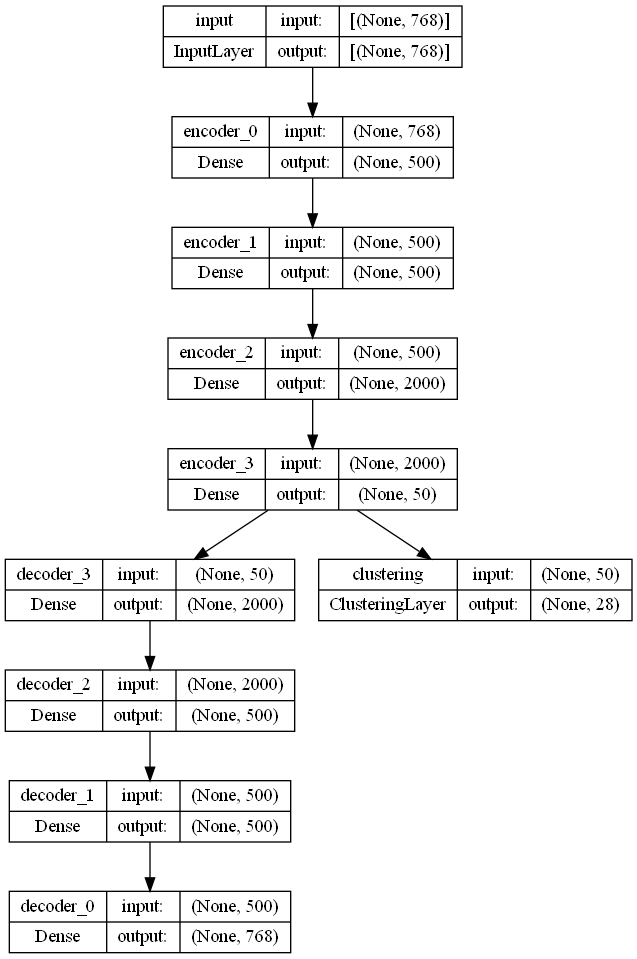

In [11]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')


In [12]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)


1037/1037 [==============================] - 1s 561us/step


In [10]:
model.compile(loss=['kld', 'mse'], loss_weights=[
              0.1, 1], optimizer=pretrain_optimizer)


In [11]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001  # tolerance threshold to stop training


In [12]:


def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T



In [16]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x, verbose=0)
        # update the auxiliary target distribution p
        p = target_distribution(q)

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' %
                  (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(
            np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index *
                      batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')


Iter 0: acc = 0.30842, nmi = 0.40107, ari = 0.18782  ; loss= 0
Iter 140: acc = 0.31460, nmi = 0.40798, ari = 0.19122  ; loss= [0.06721 0.06273 0.06093]
Iter 280: acc = 0.30498, nmi = 0.40032, ari = 0.17931  ; loss= [0.06638 0.0793  0.05845]
Iter 420: acc = 0.30911, nmi = 0.40154, ari = 0.18292  ; loss= [0.07143 0.11534 0.05989]
Iter 560: acc = 0.29325, nmi = 0.39591, ari = 0.17219  ; loss= [0.08124 0.18476 0.06276]
Iter 700: acc = 0.30212, nmi = 0.39865, ari = 0.17779  ; loss= [0.08193 0.2468  0.05725]
Iter 840: acc = 0.28722, nmi = 0.38014, ari = 0.16344  ; loss= [0.05093 0.17918 0.03301]
Iter 980: acc = 0.28417, nmi = 0.36632, ari = 0.15128  ; loss= [0.03208 0.15025 0.01706]
Iter 1120: acc = 0.29711, nmi = 0.37990, ari = 0.16077  ; loss= [0.12108 0.23409 0.09767]
Iter 1260: acc = 0.28797, nmi = 0.36521, ari = 0.15319  ; loss= [0.08369 0.20274 0.06342]
Iter 1400: acc = 0.27808, nmi = 0.36209, ari = 0.14794  ; loss= [0.05581 0.10185 0.04562]
Iter 1540: acc = 0.28882, nmi = 0.37097, ari

In [13]:

model.load_weights(save_dir + '/b_DEC_model_final.h5')


In [14]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' %
          (acc, nmi, ari), ' ; loss=', loss)


Acc = 0.30281, nmi = 0.36665, ari = 0.16285  ; loss= 0


In [19]:
len(np.unique(y_pred))


27

In [20]:
print(mapping)


{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'PRODUCT', 6: 'EVENT', 7: 'WORK_OF_ART', 8: 'LANGUAGE', 9: 'LAW', 10: 'DATE', 11: 'TIME', 12: 'PERCENT', 13: 'MONEY', 14: 'QUANTITY', 15: 'ORDINAL', 16: 'CARDINAL', 17: 'FAC'}


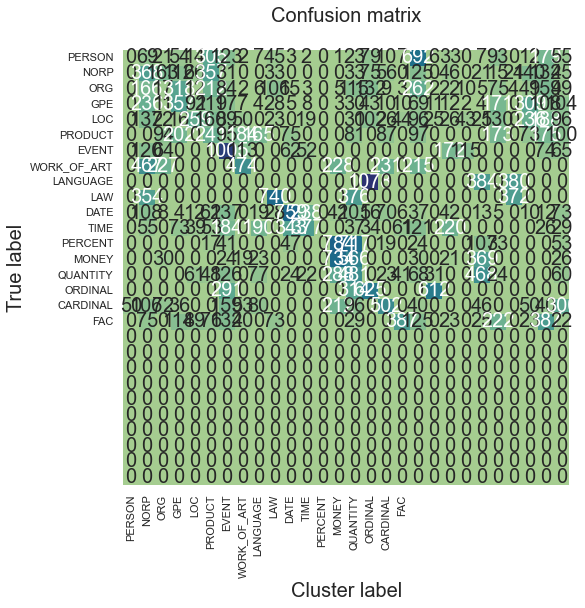

In [21]:
plot_confusion(y, y_pred, mapping, 8)


In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(i: int, cluster: dict)-> None:
    """
    Show wordcloud for a cluster.
    """
    freqs = cluster['freqs']
    frac = cluster['frac']
    n = cluster['n']
    name = cluster['name']
    print(f'{i}: "{name}", {n} items, ({frac*100:.2f}% confidence)')
    if len(freqs) > 0:
        wc = WordCloud().generate_from_frequencies(freqs)
        plt.figure(figsize=(16, 14))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    else:
        print(f"No words for cluster {cluster}")


CLUSTERS
13: "UNK-15 Was TIME", 571 items, (33.27% confidence)


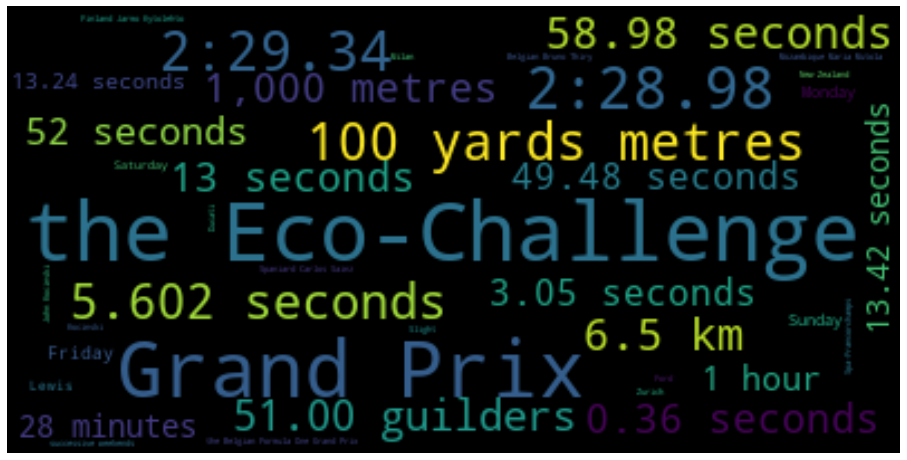

15: "UNK-26 Was CARDINAL", 1077 items, (27.86% confidence)


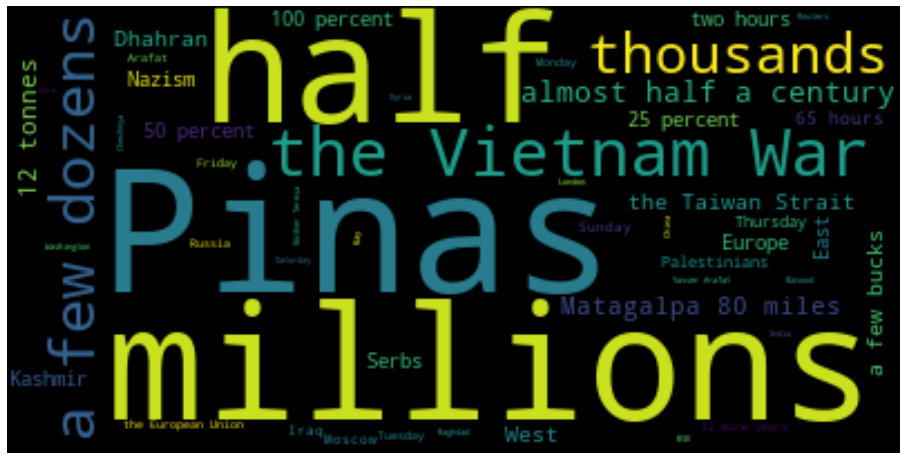

16: "UNK-22 Was FAC", 941 items, (23.59% confidence)


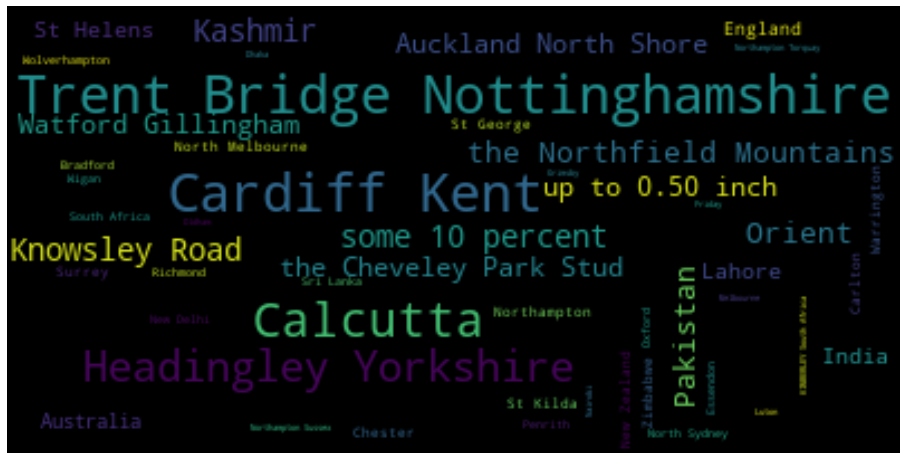

18: "UNK-21 Was WORK_OF_ART", 2261 items, (20.65% confidence)


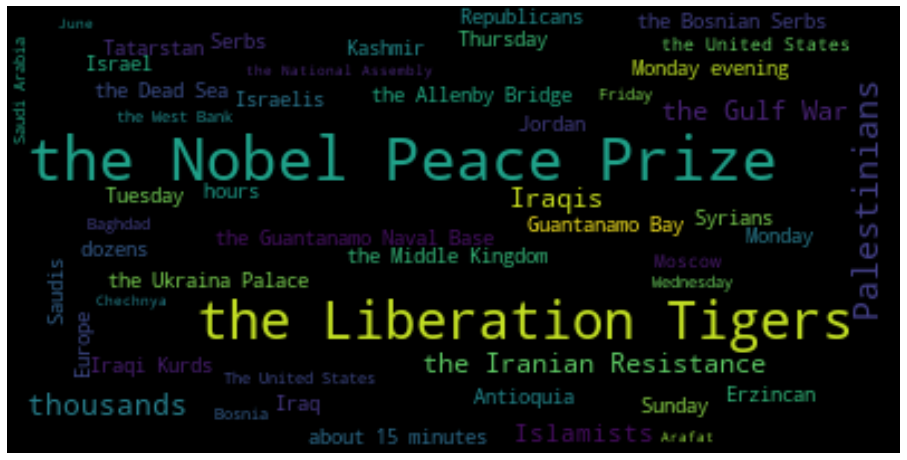

19: "UNK-7", 0 items, (0.00% confidence)
No words for cluster {'freqs': {}, 'frac': 0, 'n': 0, 'name': 'UNK-7', 'idx': 6}
0: "CARDINAL", 50 items, (100.00% confidence)


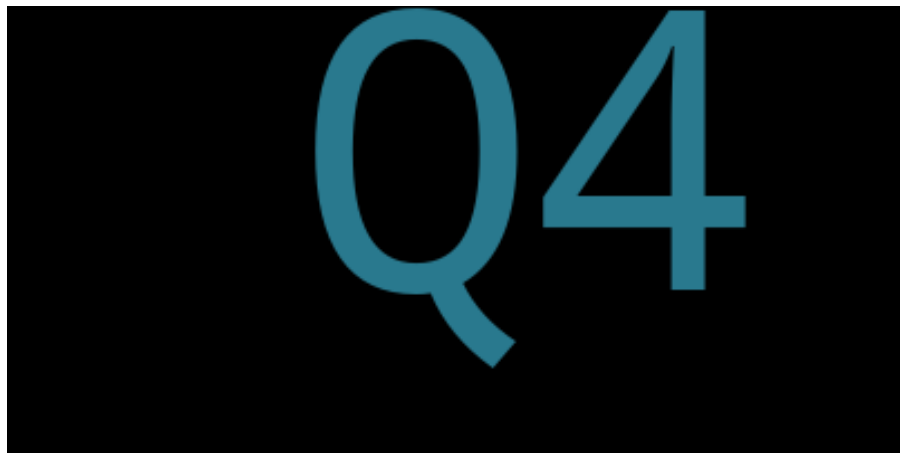

1: "ORDINAL", 687 items, (89.08% confidence)


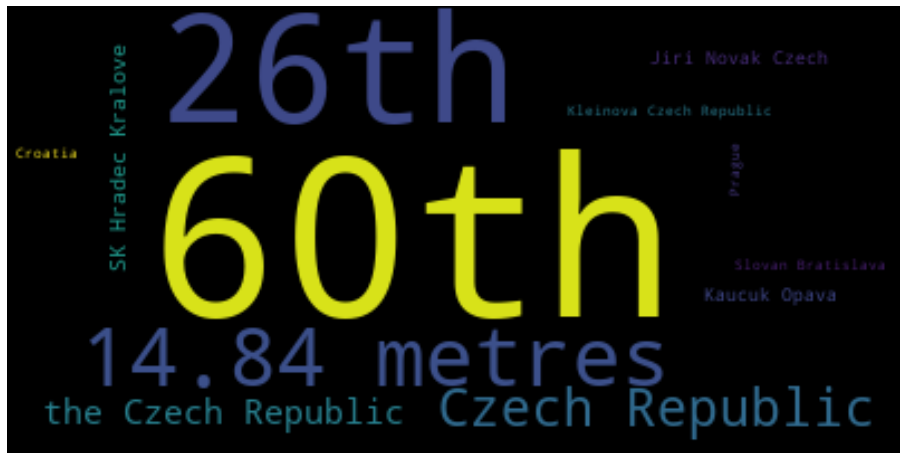

2: "FAC", 559 items, (69.23% confidence)


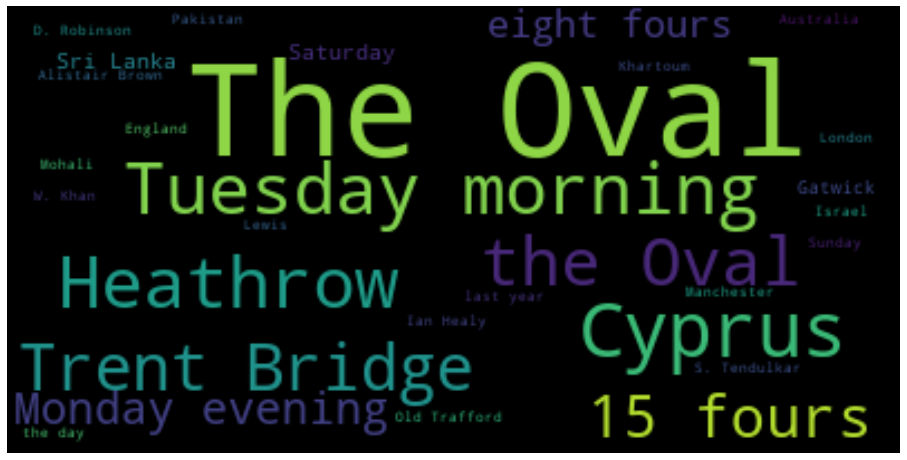

3: "LAW", 1076 items, (68.77% confidence)


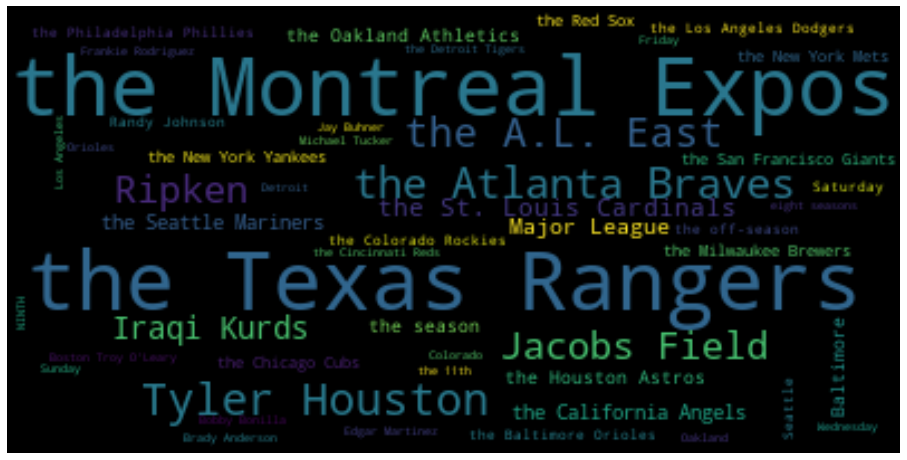

4: "EVENT", 170 items, (67.65% confidence)


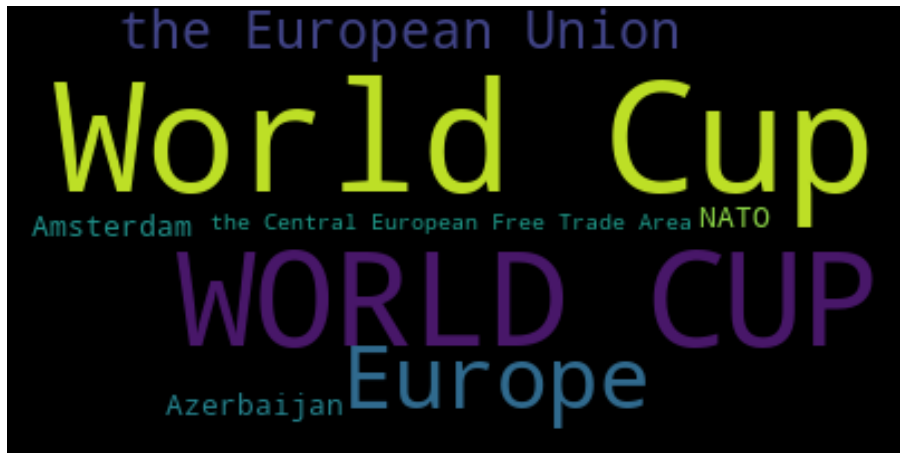

5: "DATE", 1333 items, (56.94% confidence)


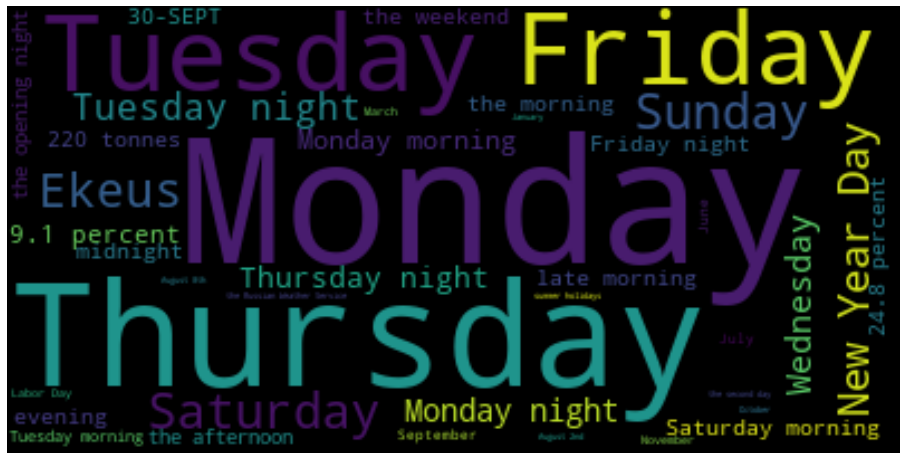

6: "TIME", 721 items, (52.29% confidence)


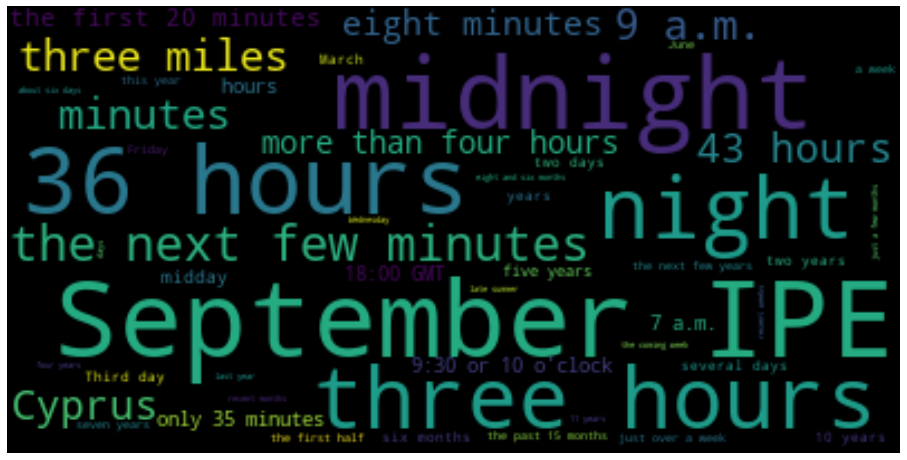

7: "WORK_OF_ART", 944 items, (50.21% confidence)


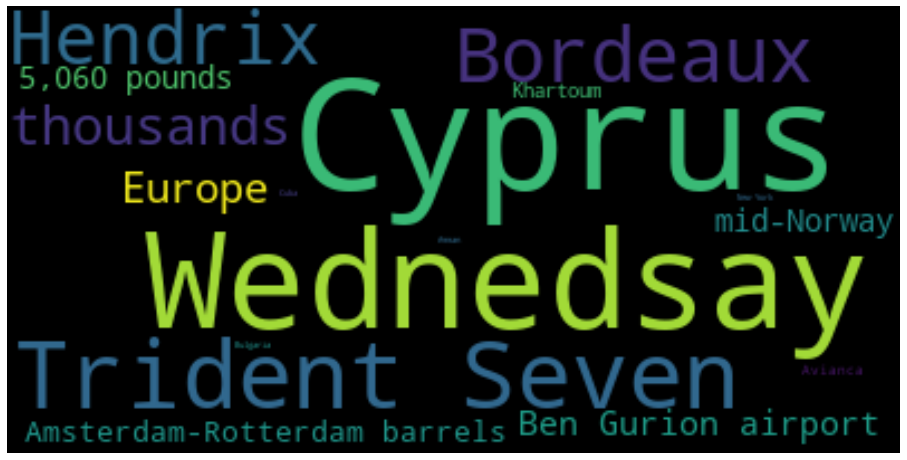

8: "LANGUAGE", 780 items, (48.72% confidence)


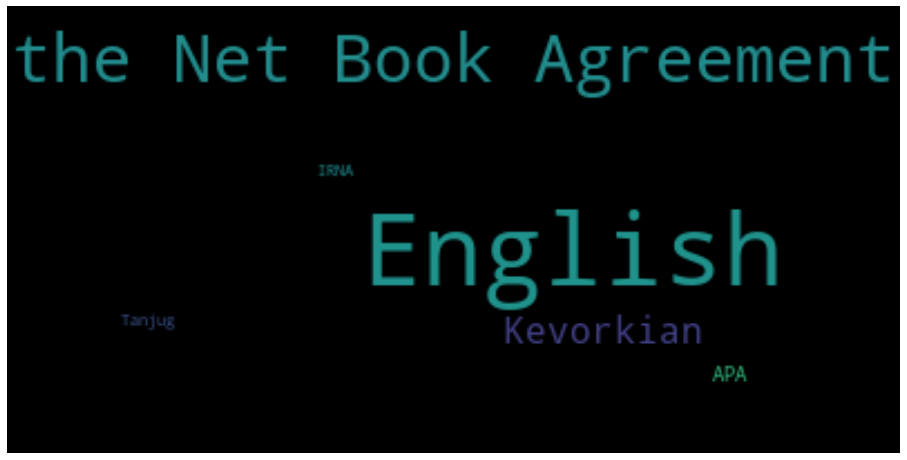

9: "LOC", 644 items, (40.22% confidence)


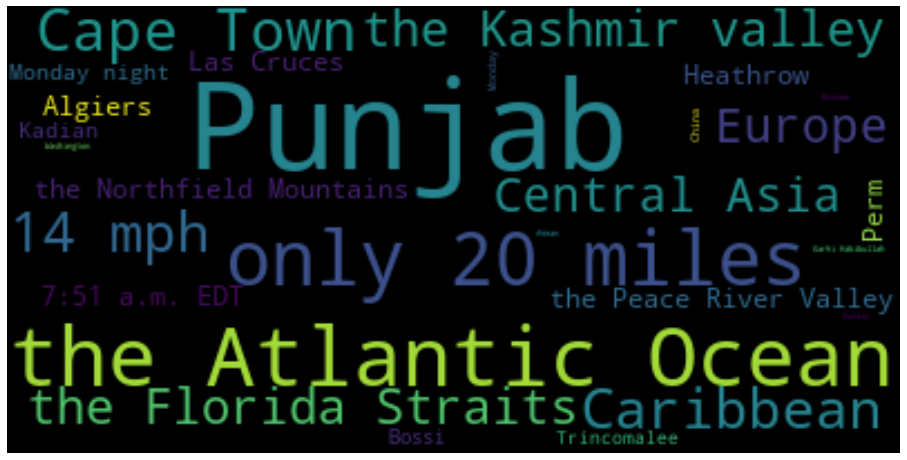

10: "PERSON", 2001 items, (34.58% confidence)


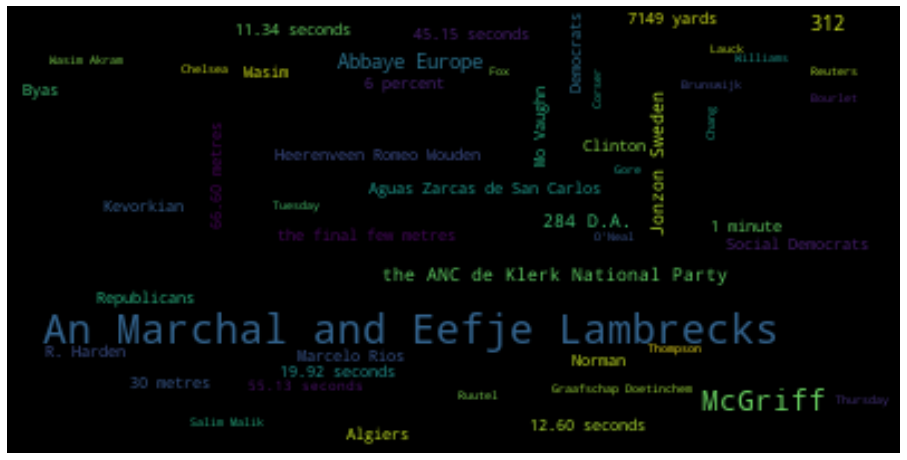

11: "GPE", 902 items, (34.26% confidence)


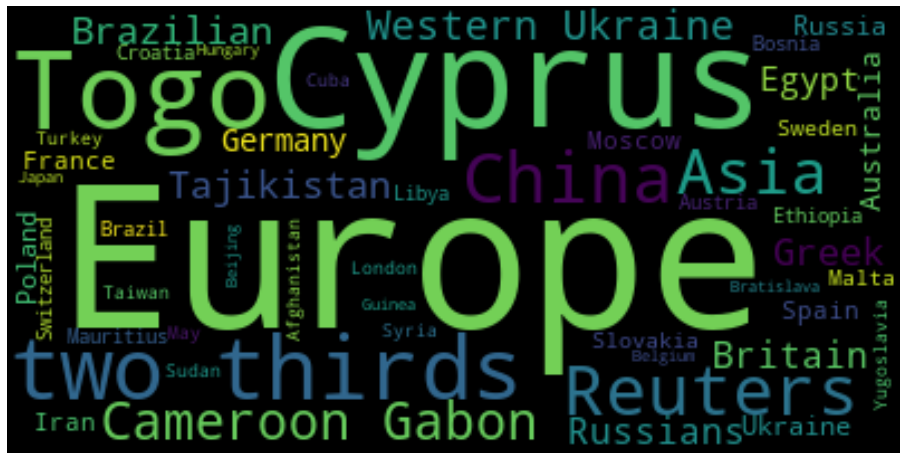

12: "PERCENT", 2297 items, (34.13% confidence)


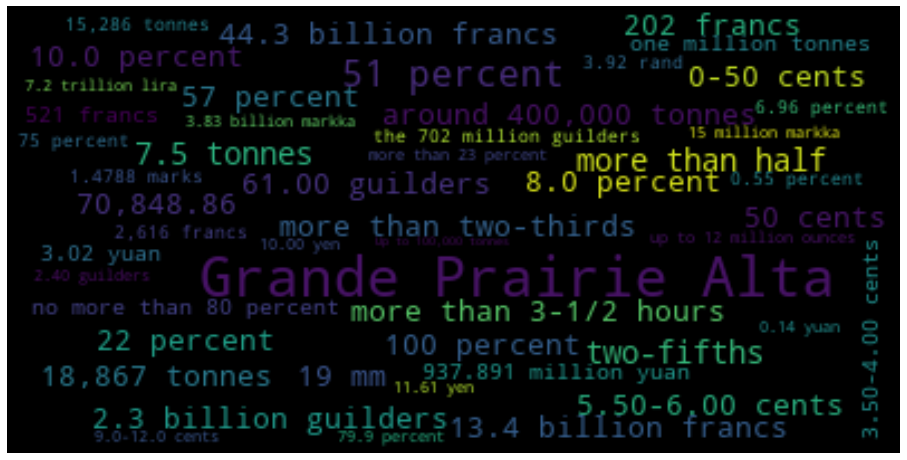

14: "QUANTITY", 1474 items, (31.75% confidence)


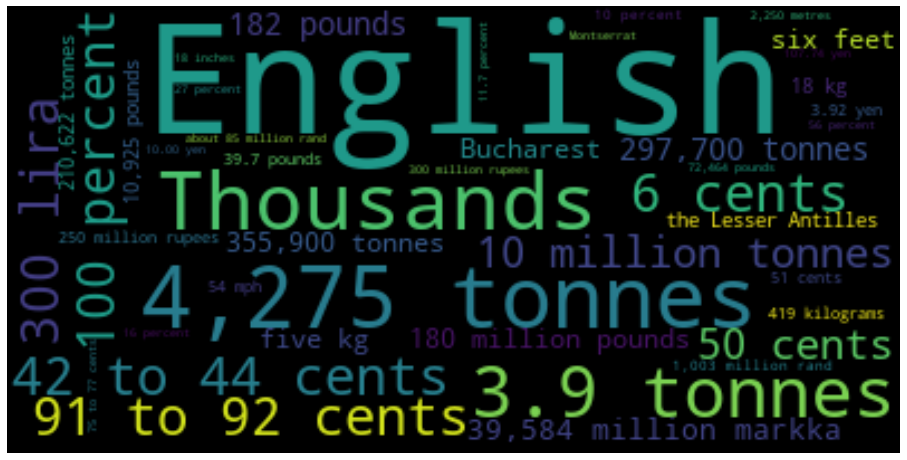

17: "NORP", 1642 items, (21.74% confidence)


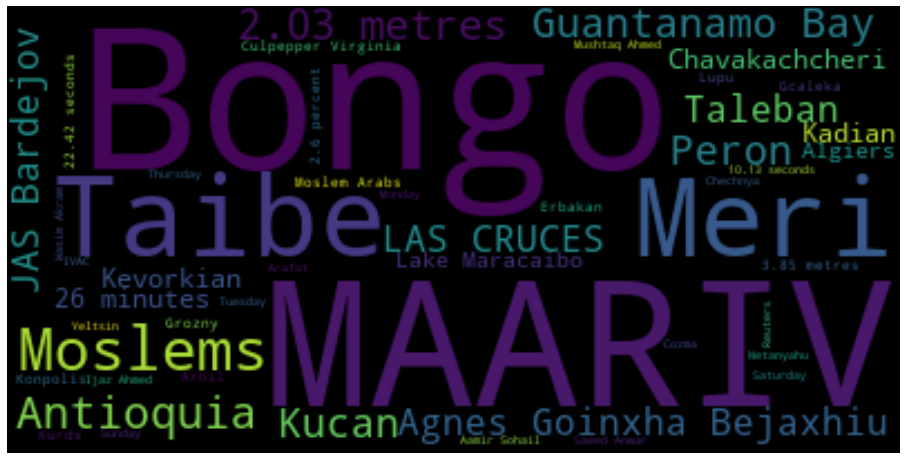

In [49]:
import numpy as np
import pandas as pd

print ("CLUSTERS")
clusters = {}
predicted = pd.DataFrame({'text':strings, 'y_pred':y_pred, 'y_true':y})
for cluster_no in range(n_clusters):
    y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
    true_label = 'UNKNOWN'
    modal_value = y_pred_for_key['y_true'].mode()
    if len(modal_value)>0:
        if modal_value[0] in mapping:
            true_label = mapping[modal_value[0]]
        # confidence - fraction of this cluster that is actually this cluster
        y_true_this_cluster = len(y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
        frac = y_true_this_cluster/len(y_pred_for_key)
    else:
        frac = 0

    # wordcloud
    unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
    freq_list = np.asarray((unique, counts)).T
    freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
    freqs = {w: f for w,f in freq_list}
    entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
    if true_label == 'UNKNOWN':
        clusters[f"UNK-{cluster_no}"] = entry
    elif true_label in clusters:
        if clusters[true_label]['frac'] < frac:
            # we found a better cluster for this label
            clusters[true_label] = entry
        else:
            # this cluster is worse than the one we already have, so it's unknown
            clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
    else:
        clusters[true_label] = entry

cluster_list = [{
    **clusters[c],
    'name': c,
    'idx': idx} for idx, c in enumerate(clusters)]
cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

# show unknown clusters first
for i, cluster in enumerate(cluster_list):
    if cluster['name'][0:3] == "UNK":
        show_wordcloud(i, cluster)

# next show known clusters
for i, cluster in enumerate(cluster_list):
    if cluster['name'][0:3] != "UNK":
        show_wordcloud(i, cluster)